# 1. Binary classification data ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
X.shape, y.shape

((1000, 2), (1000,))

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
import pandas as pd

circles = pd.DataFrame({"X1" :X[:, 0],
                        "X2" : X[:, 1],
                        'label' : y
})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [5]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

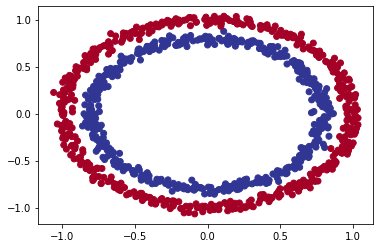

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
                    y=X[:, 1],
                    c = y,
                    cmap=plt.cm.RdYlBu) ;

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X : {X_sample} and the same for y : {y_sample}")
print(f'Shapes for one sample of y : {X_sample.shape} and the same for y : {y_sample.shape}')

Values for one sample of X : [0.75424625 0.23148074] and the same for y : 1
Shapes for one sample of y : (2,) and the same for y : ()


## Numpy to Tensor

In [9]:
import torch

# tensor 값은 실수 형태로 나옴 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

## train test split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

# 2. Building a model

In [12]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        layer_1_out = self.layer_1(x)
        layer_2_out = self.layer_2(layer_1_out) # computation goes through layer_1 first then the output of layer_1 goes through layer_2
        return layer_2_out 

In [14]:
# cpu에 적용시키겠다 
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import torchinfo

# linear에서 parameter는 weight와 bias를 의미 
torchinfo.summary(model_0,(1,2))

Layer (type:depth-idx)                   Output Shape              Param #
CircleModelV0                            [1, 1]                    --
├─Linear: 1-1                            [1, 5]                    15
├─Linear: 1-2                            [1, 1]                    6
Total params: 21
Trainable params: 21
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## loss function and optimizer

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [18]:
def accuracy_fn(y_true, y_pred) :
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Training

In [19]:
# to device를 통해 cpu에서 gpu로 모델을 보낸 후 예측 값 5개 뽑기 
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4153],
        [-0.3612],
        [-0.5288],
        [-0.3832],
        [-0.4839]], grad_fn=<SliceBackward0>)

In [20]:
# 시그모이드 활용해서 예측 값 조정 
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.3976],
        [0.4107],
        [0.3708],
        [0.4053],
        [0.3813]], grad_fn=<SigmoidBackward0>)

In [21]:
y_preds = torch.round(y_pred_prob)
# 1차원으로 바꿔준다. 
y_preds.squeeze()

tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [22]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [23]:
# 예측값과 정답값 비교
torch.eq(y_preds.squeeze(), y_test[:5])

tensor([False,  True, False,  True, False])

- training

In [24]:
# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                    y_train) 
    acc = accuracy_fn(y_true=y_train, 
                        y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71820, Accuracy: 50.00% | Test loss: 0.71697, Test acc: 50.00%
Epoch: 10 | Loss: 0.69818, Accuracy: 50.00% | Test loss: 0.70017, Test acc: 50.00%
Epoch: 20 | Loss: 0.69424, Accuracy: 40.75% | Test loss: 0.69689, Test acc: 41.50%
Epoch: 30 | Loss: 0.69342, Accuracy: 49.38% | Test loss: 0.69619, Test acc: 47.00%
Epoch: 40 | Loss: 0.69323, Accuracy: 49.75% | Test loss: 0.69598, Test acc: 46.00%
Epoch: 50 | Loss: 0.69316, Accuracy: 50.50% | Test loss: 0.69587, Test acc: 46.50%
Epoch: 60 | Loss: 0.69312, Accuracy: 50.62% | Test loss: 0.69578, Test acc: 46.00%
Epoch: 70 | Loss: 0.69310, Accuracy: 50.75% | Test loss: 0.69570, Test acc: 47.00%
Epoch: 80 | Loss: 0.69308, Accuracy: 50.50% | Test loss: 0.69562, Test acc: 46.00%
Epoch: 90 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69556, Test acc: 45.50%


# Prediction and evaluation

In [25]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


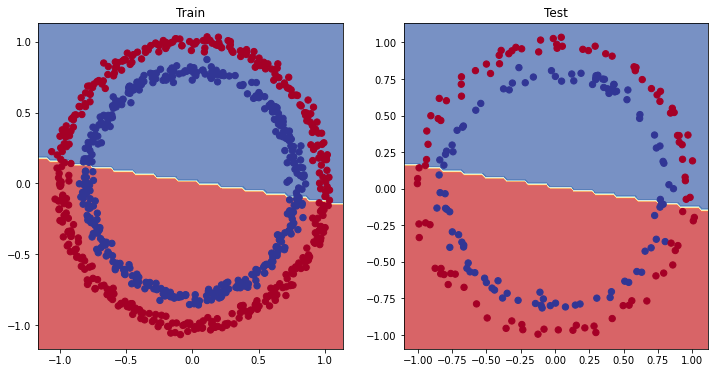

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Improving a model 
- hidden layer를 추가하면 학습을 더 시킬 수 있다. 

In [28]:
class CircleModelV1(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forword(self, x) :
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [29]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

#  Multi-class classification

In [32]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [33]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [34]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

In [35]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [36]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

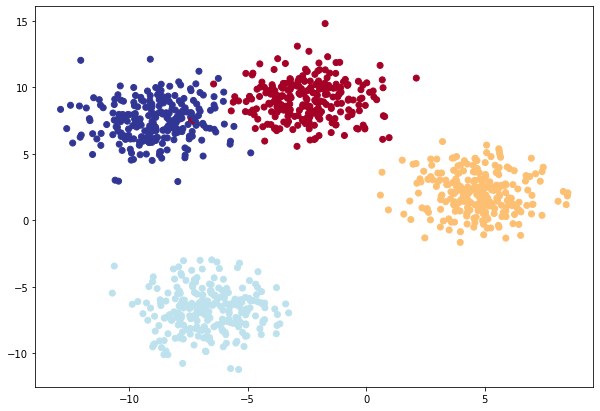

In [37]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

# Model for Multi-class Classification

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [39]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    # input parameter 정의 필요하다. 
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features), 
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [40]:
model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [41]:
torchinfo.summary(model_4, (1,2))

Layer (type:depth-idx)                   Output Shape              Param #
BlobModel                                [1, 4]                    --
├─Sequential: 1-1                        [1, 4]                    --
│    └─Linear: 2-1                       [1, 8]                    24
│    └─Linear: 2-2                       [1, 8]                    72
│    └─Linear: 2-3                       [1, 4]                    36
Total params: 132
Trainable params: 132
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Loss function and optimizer

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

## Getting predictions

In [43]:
y_logits = model_4(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-2.3091, -1.0630,  0.1396, -1.2623],
        [ 1.7678,  1.1392, -0.6276,  1.3675],
        [ 3.5359,  2.4050,  0.3818,  1.1335],
        [-1.4291, -0.5123,  0.2997, -1.0282],
        [-1.5293, -0.7446, -0.4512, -0.3044]], grad_fn=<SliceBackward0>)
tensor([[0.0529, 0.1840, 0.6124, 0.1507],
        [0.4358, 0.2324, 0.0397, 0.2920],
        [0.6869, 0.2217, 0.0293, 0.0622],
        [0.0941, 0.2354, 0.5301, 0.1405],
        [0.1049, 0.2299, 0.3082, 0.3570]], grad_fn=<SliceBackward0>)


In [44]:
# softmax는 모든 예측값의 합이 1이어야 한다. 
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [45]:
print(y_pred_probs[0])
# argmax를 이용해 softmax 값들 중 가장 큰 것의 인덱스를 출력 
print(torch.argmax(y_pred_probs[0]))

tensor([0.0529, 0.1840, 0.6124, 0.1507], grad_fn=<SelectBackward0>)
tensor(2)


## training

In [46]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 2.04111, Acc: 2.12% | Test Loss: 0.56867, Test Acc: 78.00%
Epoch: 10 | Loss: 0.14991, Acc: 99.12% | Test Loss: 0.13507, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08382, Acc: 99.25% | Test Loss: 0.07542, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06138, Acc: 99.12% | Test Loss: 0.05361, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05053, Acc: 99.12% | Test Loss: 0.04270, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04426, Acc: 99.12% | Test Loss: 0.03625, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04022, Acc: 99.12% | Test Loss: 0.03201, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03742, Acc: 99.12% | Test Loss: 0.02904, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03539, Acc: 99.12% | Test Loss: 0.02683, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03385, Acc: 99.12% | Test Loss: 0.02513, Test Acc: 99.50%


In [47]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  5.2248,  10.5397, -11.2470,  -8.1411],
        [  3.8833, -10.8430,   2.1998,   9.5526],
        [ -9.3145, -13.6066,  18.5762,  10.0771],
        [  1.8742,   7.5040,  -5.7862,  -6.0568],
        [  9.1429,   4.2958, -12.1643,  -2.3912],
        [  4.3030, -13.5581,   3.2440,  11.8792],
        [ -9.4832, -10.6364,  17.1074,   7.5712],
        [  7.5200,   0.2681,  -8.0915,   0.7562],
        [ -9.8291, -18.6473,  21.9690,  14.2213],
        [  7.9581,   1.7217,  -9.3955,  -0.3996]])